In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 读取数据集
def load_data():
    # 读取训练集
    train_file = open("./toutiao_category_train.txt", encoding='utf-8')
    train_collection = train_file.readlines()
    train_data = []
    for i in train_collection:
        i = i.split("_!_")
        i.append(len(i[4].split(",")))
        i[4] = i[4].strip()
        i[4] = " ".join(i[4].split(","))
        i.pop(0)
        train_data.append(i)
    train_df = pd.DataFrame(train_data)
    train_df.columns = ["label_index", "label", "title", "cutword", "cutwordnum"]
    
    # 读取验证集
    val_file = open("./toutiao_category_dev.txt", encoding='utf-8')
    val_collection = val_file.readlines()
    val_data = []
    for i in val_collection:
        i =i.split("_!_")
        i.append(len(i[4].split(",")))
        i[4] = i[4].strip()
        i[4] =  " ".join(i[4].split(","))
        i.pop(0)
        val_data.append(i)
    val_df = pd.DataFrame(val_data)
    val_df.columns = ["label_index", "label", "title", "cutword", "cutwordnum"]
    
    # 读取测试集
    test_file = open("./toutiao_category_test.txt", encoding='utf-8')
    test_collection = test_file.readlines()
    test_data = []
    for i in test_collection:
        i =i.split("_!_")
        i.append(len(i[4].split(",")))
        i[4] = i[4].strip()
        i[4] =  " ".join(i[4].split(","))
        i.pop(0)
        test_data.append(i)
    test_df = pd.DataFrame(test_data)
    test_df.columns = ["label_index", "label", "title", "cutword", "cutwordnum"]
    
    return train_df, val_df, test_df

In [3]:
train_df, val_df, test_df = load_data()

In [4]:
train_df.head()

,label_index,label,title,cutword,cutwordnum
0,104,news_finance,股票中的突破形态,股票,1
1,102,news_entertainment,他是最帅的古装男神，10国语言六门武术，演技在线却常演配角！,三生三世十里桃花 张智尧 杨门女将之女儿当自强 陆小凤 印象深刻 陆小凤传奇 杨宗保 花满楼...,9
2,102,news_entertainment,陈伟霆和黄晓明真的有差别，难怪baby会选择黄晓明,陈伟霆 黄晓明 粉丝,3
3,107,news_car,驾驶证科目几最难？,驾驶证 科目,2
4,104,news_finance,紫贝龙2017年营收1644万元 业绩亏损1425万元,上年同期 紫贝龙,2


数据探索

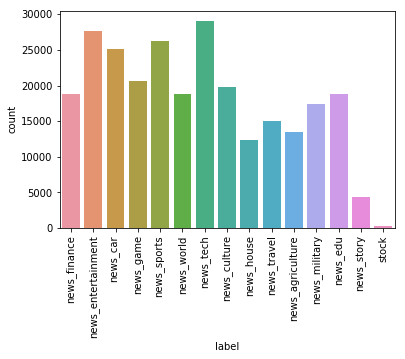

In [5]:
## 查看训练集都有哪些标签
plt.figure()
sns.countplot(train_df.label)
plt.xlabel('label')
plt.xticks(rotation=90)
plt.show()

共15种标签，标签分布比较均匀。

count    267881.00000
mean          3.84844
std           2.66363
min           1.00000
25%           1.00000
50%           5.00000
75%           5.00000
max          20.00000
Name: cutwordnum, dtype: float64


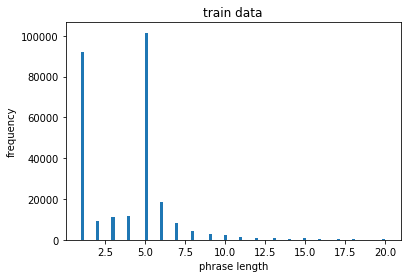

In [6]:
## 分析训练集中词组数量的分布
print(train_df.cutwordnum.describe())
plt.figure()
plt.hist(train_df.cutwordnum,bins=100)
plt.xlabel("phrase length")
plt.ylabel("frequency")
plt.title("train data")
plt.show()

In [7]:
## 对数据集的标签数据进行重新编码
train_y = train_df.label
val_y = val_df.label
test_y = test_df.label
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
val_y = le.transform(val_y).reshape(-1,1)
test_y = le.transform(test_y).reshape(-1,1)

## 对数据集的标签数据进行one-hot编码
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y).toarray()
val_y = ohe.transform(val_y).toarray()
test_y = ohe.transform(test_y).toarray()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


使用Tokenizer对词组进行编码

In [8]:
max_words = 5000
max_len = 600
tok = Tokenizer(num_words=max_words)  ## 使用的最大词语数为5000
tok.fit_on_texts(train_df.cutword)

## 使用word_index属性可以看到每次词对应的编码
## 使用word_counts属性可以看到每个词对应的频数
for ii,iterm in enumerate(tok.word_index.items()):
    if ii < 10:
        print(iterm)
    else:
        break
print("===================")  
for ii,iterm in enumerate(tok.word_counts.items()):
    if ii < 10:
        print(iterm)
    else:
        break

('游戏', 1)
('农村', 2)
('俄罗斯', 3)
('suv', 4)
('东方ic', 5)
('美国', 6)
('伊朗', 7)
('nba', 8)
('詹姆斯', 9)
('日本', 10)
('股票', 796)
('三生三世十里桃花', 183)
('张智尧', 12)
('杨门女将之女儿当自强', 1)
('陆小凤', 9)
('印象深刻', 3)
('陆小凤传奇', 6)
('杨宗保', 4)
('花满楼', 3)
('古剑奇谭', 104)


使用tok.texts_to_sequences()将数据转化为序列，并使用sequence.pad_sequences()将每个序列调整为相同的长度。

In [9]:
## 对每个词编码之后，每句新闻中的每个词就可以用对应的编码表示，即每条新闻可以转变成一个向量了：
train_seq = tok.texts_to_sequences(train_df.cutword)
val_seq = tok.texts_to_sequences(val_df.cutword)
test_seq = tok.texts_to_sequences(test_df.cutword)
## 将每个序列调整为相同的长度
train_seq_mat = sequence.pad_sequences(train_seq,maxlen=max_len)
val_seq_mat = sequence.pad_sequences(val_seq,maxlen=max_len)
test_seq_mat = sequence.pad_sequences(test_seq,maxlen=max_len)

print(train_seq_mat.shape)
print(val_seq_mat.shape)
print(test_seq_mat.shape)

(267881, 600)
(57403, 600)
(57404, 600)


建立LSTM模型并训练

In [13]:
## 定义LSTM模型
inputs = Input(name='inputs',shape=[max_len])
## Embedding(词汇表大小,batch大小,每个新闻的词长)
layer = Embedding(max_words+1,128,input_length=max_len)(inputs)
layer = LSTM(128)(layer)
layer = Dense(128,activation="relu",name="FC1")(layer)
layer = Dropout(0.5)(layer)
layer = Dense(15,activation="softmax",name="FC2")(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 600)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 600, 128)          640128    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
FC1 (Dense)                  (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 15)                1935      
Total params: 790,159
Trainable params: 790,159
Non-trainable params: 0
_____________________________________________________

模型建立好之后，开始进行训练

In [14]:
## 模型训练
model_fit = model.fit(train_seq_mat,train_y,batch_size=128,epochs=10,
                      validation_data=(val_seq_mat,val_y),
                      callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)] ## 当val-loss不再提升时停止训练
                     )

W0113 15:45:41.571940 12528 module_wrapper.py:139] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 267881 samples, validate on 57403 samples
Epoch 1/10
267881/267881 [==============================] - 3724s 14ms/step - loss: 1.6711 - accuracy: 0.4768 - val_loss: 1.4363 - val_accuracy: 0.5460
Epoch 2/10
267881/267881 [==============================] - 3766s 14ms/step - loss: 1.4367 - accuracy: 0.5484 - val_loss: 1.4075 - val_accuracy: 0.5483
Epoch 3/10
267881/267881 [==============================] - 3793s 14ms/step - loss: 1.4087 - accuracy: 0.5530 - val_loss: 1.4000 - val_accuracy: 0.5482
Epoch 4/10
267881/267881 [==============================] - 4015s 15ms/step - loss: 1.4015 - accuracy: 0.5539 - val_loss: 1.4026 - val_accuracy: 0.5491


In [16]:
## 对测试集进行预测
test_pre = model.predict(test_seq_mat)

## 评价预测效果，计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1))

In [29]:
list(train_df.label.drop_duplicates())

['news_finance',
 'news_entertainment',
 'news_car',
 'news_game',
 'news_sports',
 'news_world',
 'news_tech',
 'news_culture',
 'news_house',
 'news_travel',
 'news_agriculture',
 'news_military',
 'news_edu',
 'news_story',
 'stock']

In [23]:
Labname =  list(train_df.label.drop_duplicates())

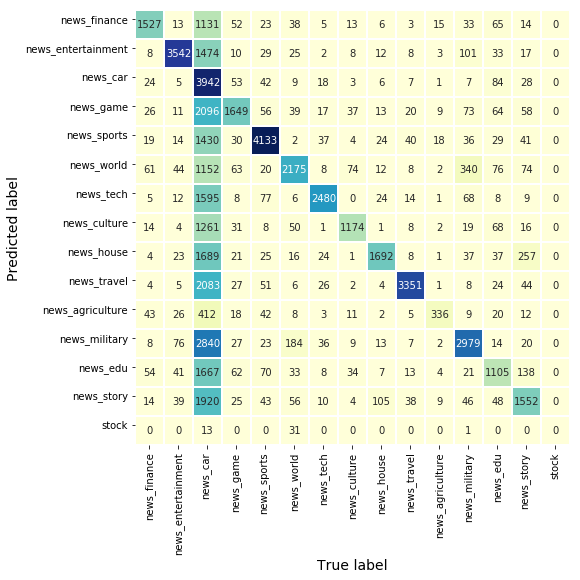

              precision    recall  f1-score   support

           0       0.52      0.84      0.64      1811
           1       0.67      0.92      0.78      3855
           2       0.93      0.16      0.27     24705
           3       0.40      0.79      0.53      2076
           4       0.71      0.89      0.79      4642
           5       0.53      0.81      0.64      2678
           6       0.58      0.93      0.71      2675
           7       0.44      0.85      0.58      1374
           8       0.44      0.88      0.59      1921
           9       0.59      0.95      0.73      3530
          10       0.35      0.83      0.50       404
          11       0.48      0.79      0.59      3778
          12       0.34      0.66      0.45      1675
          13       0.40      0.68      0.50      2280
          14       0.00      0.00      0.00         0

    accuracy                           0.55     57404
   macro avg       0.49      0.73      0.55     57404
weighted avg       0.71   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [30]:
## 混淆矩阵可视化
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.xticks(np.arange(15)+0.5,Labname,rotation=90)
plt.yticks(np.arange(15)+0.3,Labname,rotation=0)
plt.show()


print(metrics.classification_report(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1)))

训练时间：5小时，准确率：55%

In [31]:
## 保存训练好的Tokenizer，和导入
import pickle
# saving
with open('tok.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
# # loading
# with open('tok.pickle', 'rb') as handle:
#     tok = pickle.load(handle)
# ## 使用word_index属性可以看到每次词对应的编码
# ## 使用word_counts属性可以看到每个词对应的频数
# for ii,iterm in enumerate(tok.word_index.items()):
#     if ii < 10:
#         print(iterm)
#     else:
#         break
# print("===================")  
# for ii,iterm in enumerate(tok.word_counts.items()):
#     if ii < 10:
#         print(iterm)
#     else:
#         break

In [33]:
## 模型的保存和导入
from keras.models import load_model
# 保存模型
model.save('LSTM_tnews_model.h5')  

In [ ]:
# # 导入已经训练好的模型
# model = load_model('my_model.h5')
# ## 使用tok对验证数据集重新预处理
# val_seq = tok.texts_to_sequences(val_df.cutword)
# ## 将每个序列调整为相同的长度
# val_seq_mat = sequence.pad_sequences(val_seq,maxlen=max_len)
# ## 对验证集进行预测
# val_pre = model.predict(val_seq_mat)
# print(metrics.classification_report(np.argmax(val_pre,axis=1),np.argmax(val_y,axis=1)))